In [168]:
# !pip install statsmodels patsy
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import datetime
import warnings

warnings.filterwarnings("ignore")
%xmode verbose
sns.set()
np.random.seed(4)

Exception reporting mode: Verbose


# Importing datasets

In [5]:
# Mythri Nagar data => 5th May to 15th May (11 days) > Train on `08` days > Test on `03` days
# Labbipet_New data => 5th May to 18th May (14 days) > Train on `10` days > Test on `04` days
!ls

Complete.ipynb
food-consumption.csv
interpolated_time.png
Labbipet_New.xls
miss_time_series.png
Missing data.ipynb
missing_data.csv
missing-data.csv
missing-data2.csv
Mythri Nagar.xls
sanger-machine-learning-workshop


****************

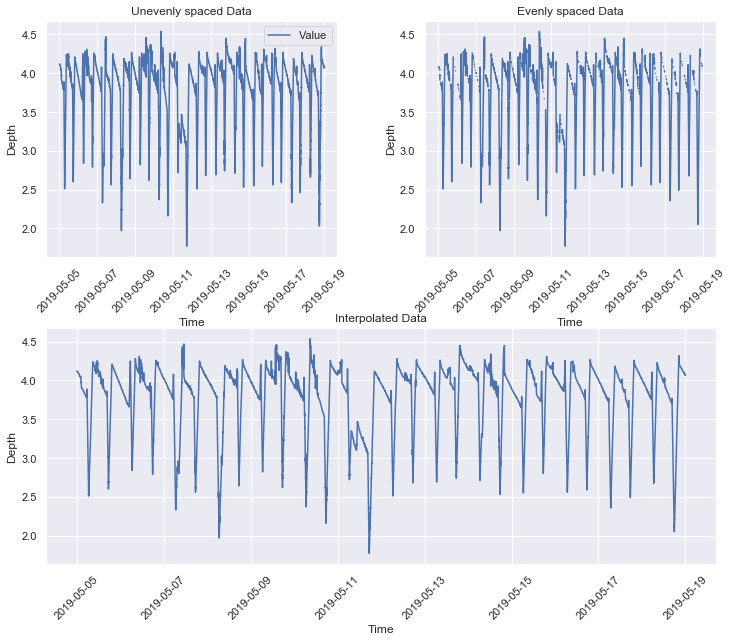

In [117]:
df = pd.read_csv("labbipet.csv")
df.index = pd.to_datetime(df["Date"] + " " + df["Time"])
df.drop(["Date", "Time"], inplace=True, axis=1)

time_range = pd.date_range(start="2019-05-05 00:00:00", end="2019-05-18 23:59:00", periods=24*60*14)
data = pd.DataFrame({"Values": np.full((24*60*14), fill_value=np.nan)}, index=time_range)

for i in range(len(data)):
    if i == len(data)-1:
        data["Values"][i] = df.loc[data.index[i]:].values.mean()   
    else:
        data["Values"][i] = df.loc[data.index[i]:data.index[i+1]].values.mean()
        
series = pd.Series(data.values.ravel(), index = data.index)
series.interpolate(method='time', limit_direction='both', inplace=True)

fig = plt.figure(figsize=(12,10))
gs = matplotlib.gridspec.GridSpec(nrows=2, ncols=2, hspace=0.3, wspace=0.3, figure=fig)

ax1 = fig.add_subplot(gs[0,0])
sns.lineplot(data=df, ax=ax1)
ax1.set_xlabel("Time")
ax1.set_ylabel("Depth")
ax1.set_title("Unevenly spaced Data")
plt.xticks(rotation=45)

ax2 = fig.add_subplot(gs[0,1])
plt.plot(data)
ax2.set_xlabel("Time")
ax2.set_ylabel("Depth")
ax2.set_title("Evenly spaced Data")
plt.xticks(rotation=45)

ax3 = fig.add_subplot(gs[1,:])
sns.lineplot(data=series, ax=ax3)
ax3.set_xlabel("Time")
ax3.set_ylabel("Depth")
ax3.set_title("Interpolated Data")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [175]:
std_scaler = StandardScaler()
series = pd.Series(std_scaler.fit_transform(series.values.reshape(-1,1)).reshape(-1), index=series.index)

# Anomaly detection

In [178]:
def make_chunks(data, segment_len=32, sliding_len=2):
    segments= []

    for start_pos in range(0, len(data), sliding_len):
        end_pos = start_pos + segment_len

        segment = np.copy(data[start_pos:end_pos])

        if not len(segment) == segment_len:
            continue

        segments.append(segment)

    segments = np.array(segments) 
    return segments

In [179]:
def plot_waves(waves, step=2):
    plt.figure()
    n_graph_rows = 3
    n_graph_cols = 3
    graph_n = 1
    wave_n = 0
    for _ in range(n_graph_rows):
        for _ in range(n_graph_cols):
            axes = plt.subplot(n_graph_rows, n_graph_cols, graph_n)
            plt.plot(waves[wave_n])
            graph_n += 1
            wave_n += step
    plt.tight_layout()
    plt.show()

In [180]:
def windowing_func(segment_len, plot=False):
    vals = np.linspace(0, np.pi, segment_len)
    window_func = np.sin(vals)**2
    if plot:
        plt.plot(window_func)
        plt.show()
    return window_func

def normalize_waves(segments, window_func):
    windowed_segments = []
    for segment in segments:
        windowed_segments.append(np.copy(segment) * window_func)
    windowed_segments = np.array(windowed_segments)
    return windowed_segments

In [205]:
def reconstruct(data, window_func, clusterer):
    window_len = len(window_func)
    slide_len = window_len//2
    segments = make_chunks(data, window_len, slide_len)
    reconstructed_data = np.zeros(len(data))
    for segment_n, segment in enumerate(segments):
        segment *= window_func
        nearest_match_idx = clusterer.predict(np.expand_dims(segment, axis=0))[0]
        nearest_match = np.copy(clusterer.cluster_centers_[nearest_match_idx])

        pos = segment_n * slide_len
        reconstructed_data[pos:pos+window_len] += nearest_match

    return np.array(reconstructed_data)

In [229]:
def reconstruction_error(test_data, window_func, kmeans):
    recons = reconstruct(test_data, window_func, kmeans)

    error = recons - test_data

    max_err = error.max()
    error_98 = np.percentile(error, 98)
#     print("Maximum error:", max_err)
#     print("98% of error:", error_98)

#     plt.figure(figsize=(12,8))
#     plt.plot(test_data, "-", label="Original data", alpha=0.5)
#     plt.plot(recons, "--", label="Reconstructed data", alpha=0.5)
#     plt.plot(error, label="Reconstruction Error", alpha=1)
#     plt.plot(list(range(len(recons))), np.ones_like(recons)*error.max(), alpha=0.8, color="red")
#     plt.plot(list(range(len(recons))), np.ones_like(recons)*error.min(), alpha=0.8, color="red")
#     plt.legend()
#     plt.show()
    
    return max_err, error_98

In [224]:
type(series)

pandas.core.series.Series

In [225]:
len(series)

20160

In [230]:
def test_error(seg_len, n_clusters):
    segments = make_chunks(series.values, segment_len=seg_len)
#     print("**************Segments**************")
#     plot_waves(segments, step=10)

    window_fn = windowing_func(segment_len=seg_len)
    normal_segments = normalize_waves(segments, window_fn)
#     print("**************Normal segments**************")
#     plot_waves(normal_segments, step=10)

    clusterer = KMeans(n_clusters)
    clusterer.fit(normal_segments)

#     print("**************Cluster centers**************")
#     plot_waves(clusterer.cluster_centers_, step=10)

    slide_len = seg_len//2
    test_segments = make_chunks(series.values, segment_len=seg_len, sliding_len=slide_len)

    return reconstruction_error(series.values, window_fn, clusterer)
    

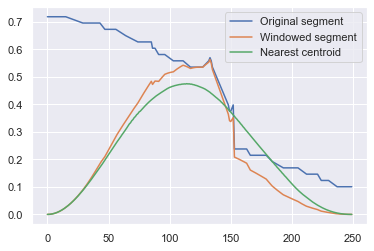

In [219]:
centroids = clusterer.cluster_centers_

segment = np.copy(test_segments[0])
# remember, the clustering was set up using the windowed data
# so to find a match, we should also window our search key
windowed_segment = segment * window_fn
# predict() returns a list of centres to cope with the possibility of multiple
# samples being passed
nearest_centroid_idx = clusterer.predict(windowed_segment.reshape(1,-1))[0]
nearest_centroid = np.copy(centroids[nearest_centroid_idx])
plt.figure()
plt.plot(segment, label="Original segment")
plt.plot(windowed_segment, label="Windowed segment")
plt.plot(nearest_centroid, label="Nearest centroid")
plt.legend()
plt.show()

In [ ]:
max_errs = {}
err_98s = {}
segs = list(range(100, 1500, 50))
clusts = list(range(100, 900, 50))

total = len(segs) + len(clusts)

for seglen in segs:
    max_errs[seglen] = []
    err_98s[seglen] = []
    for clstr_size in clusts:
        print(total, "to go", end="\r")
        max_err, err_98 = test_error(seglen, clstr_size)
        max_errs[seglen].append(max_err)
        err_98s[seglen].append(err_98)
        total -= 1